# 갑상선암 진단 분류 대회 제출 노트북

- **제출자:** 이준서 / ribertad21@gmail.com
- **사용 모델:** XGBoost + LightGBM + CatBoost (Soft Voting Ensemble)
- **사용 기법:** SMOTE, Label Encoding, F1 Score 기반 Threshold 최적화, 가중 Soft Voting
- **평가 지표:** Binary F1 Score 기준
- **입출력 경로:** `/data/` 기준 경로 사용

## ✅ 개발 환경 정보

- **OS:** Windows 10
- **Python 버전:** 3.13.2
- **사용 라이브러리 및 버전**
  - pandas==2.2.3  
  - numpy==2.2.4  
  - scikit-learn==1.6.1  
  - xgboost==2.1.1  
  - lightgbm==4.6.0  
  - catboost==1.2.8  
  - matplotlib==3.10.1  
  - seaborn==0.13.2  
  - imbalanced-learn==0.13.0



In [24]:
# ==============================================
# 1. 라이브러리 로딩 및 환경 정보
# ==============================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, classification_report, confusion_matrix, precision_recall_curve
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from imblearn.over_sampling import SMOTE


In [25]:
# ==============================================
# 2. 데이터 로딩
# ==============================================
def get_path(filename):
    return "/data/" + filename if os.path.exists("/data") else "data/" + filename

train = pd.read_csv(get_path("train.csv"))
test = pd.read_csv(get_path("test.csv"))

X = train.drop(columns=["ID", "Cancer"])
y = train["Cancer"]
X_test = test.drop(columns=["ID"])

In [26]:
# ==============================================
# 3. 전처리: 범주형 인코딩
# ==============================================
categorical_cols = X.select_dtypes(include='object').columns
encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])
    encoders[col] = le

for col in categorical_cols:
    le = encoders[col]
    X_test[col] = X_test[col].map(lambda s: '<UNK>' if s not in le.classes_ else s)
    le.classes_ = np.append(le.classes_, '<UNK>')
    X_test[col] = le.transform(X_test[col])

In [27]:
# ==============================================
# 4. 중요도 시각화 전용 모델 학습
# ==============================================

# 전처리 완료된 전체 X, y 사용
X_train_f, X_val_f, y_train_f, y_val_f = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
smote = SMOTE(random_state=42)
X_train_res_f, y_train_res_f = smote.fit_resample(X_train_f, y_train_f)

model_full = XGBClassifier(random_state=42, eval_metric='logloss')
model_full.fit(X_train_res_f, y_train_res_f)
_= model_full

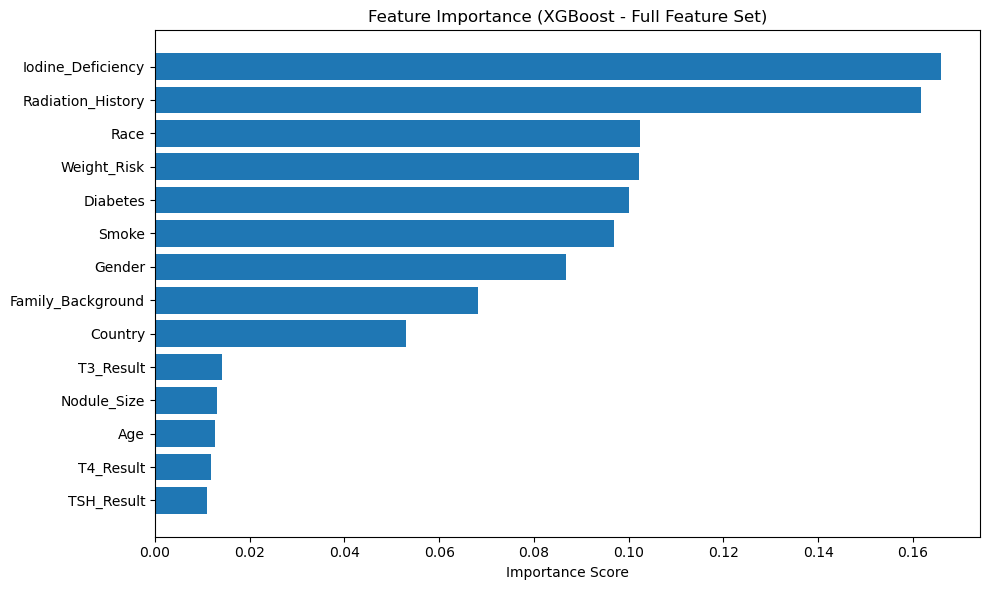

In [28]:
# ==============================================
# 5. Feature Importance 시각화 (전체 feature 기준)
# ==============================================
importances = model_full.feature_importances_
features = X_train_res_f.columns.tolist()

feature_importance = list(zip(features, importances))
feature_importance.sort(key=lambda x: x[1], reverse=True)

sorted_features = [f[0] for f in feature_importance]
sorted_importances = [f[1] for f in feature_importance]

plt.figure(figsize=(10, 6))
plt.title("Feature Importance (XGBoost - Full Feature Set)")
plt.barh(range(len(sorted_features)), sorted_importances[::-1], align="center")
plt.yticks(range(len(sorted_features)), sorted_features[::-1])
plt.xlabel("Importance Score")
plt.tight_layout()
plt.show()


In [29]:
# ==============================================
# 6. 중요도 낮은 feature 제거 후 재정의
# ==============================================
drop_features = ["T3_Result", "Nodule_Size", "Age", "T4_Result", "TSH_Result"]
X = X.drop(columns=drop_features)
X_test_dropped = X_test.drop(columns=drop_features)  # drop된 X_test는 따로 저장

In [30]:
# ==============================================
# 7. 모델 학습 (앙상블: XGB + LGBM + CatBoost)
# ==============================================
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

xgb = XGBClassifier(random_state=42, eval_metric='logloss')
lgbm = LGBMClassifier(random_state=42)
cat = CatBoostClassifier(verbose=0, random_state=42)

xgb.fit(X_train_res, y_train_res)
lgbm.fit(X_train_res, y_train_res)
cat.fit(X_train_res, y_train_res)

[LightGBM] [Info] Number of positive: 61360, number of negative: 61360
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004291 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 29
[LightGBM] [Info] Number of data points in the train set: 122720, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


In [31]:
# ==============================================
# 8. Threshold 최적화
# ==============================================
xgb_val = xgb.predict_proba(X_val)[:, 1]
lgbm_val = lgbm.predict_proba(X_val)[:, 1]
cat_val = cat.predict_proba(X_val)[:, 1]

weights = {'xgb': 1.0, 'lgbm': 1.0, 'cat': 1.5}
total_weight = sum(weights.values())

ensemble_val = (
    xgb_val * weights['xgb'] +
    lgbm_val * weights['lgbm'] +
    cat_val * weights['cat']
) / total_weight

precisions, recalls, thresholds = precision_recall_curve(y_val, ensemble_val)
f1s = 2 * (precisions * recalls) / (precisions + recalls + 1e-8)
best_idx = np.argmax(f1s)
best_threshold = thresholds[best_idx]
print(f"Best Threshold: {best_threshold:.4f}, Best F1 Score: {f1s[best_idx]:.4f}")

Best Threshold: 0.6093, Best F1 Score: 0.4629


In [32]:
# ==============================================
# 9. 테스트셋 예측 및 제출 저장
# ==============================================
xgb_test = xgb.predict_proba(X_test_dropped)[:, 1]
lgbm_test = lgbm.predict_proba(X_test_dropped)[:, 1]
cat_test = cat.predict_proba(X_test_dropped)[:, 1]

ensemble_test = (
    xgb_test * weights['xgb'] +
    lgbm_test * weights['lgbm'] +
    cat_test * weights['cat']
) / total_weight

final_pred = (ensemble_test >= best_threshold).astype(int)

submission = pd.read_csv(get_path("sample_submission.csv"))
submission['Cancer'] = final_pred
submission.to_csv(get_path("submission.csv"), index=False)
print("제출 파일이 저장되었습니다 →", get_path("submission.csv"))

제출 파일이 저장되었습니다 → data/submission.csv
